In [1]:
import torch, math
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath("../../.."))
from Forward.mag3D import mag3D_8091
from Forward.utils import get_B0_and_m, compute_kernel

In [2]:
model_npz = np.load("../../../models/Model_prueba/magnetometry_model_CM2.npz")


model = model_npz["suscep"]
cell_centers = model_npz["cell_centers"]    # (nx, ny, nz), bool
dx = model_npz["dx"]                      # (nx, ny, nz)
dy = model_npz["dy"]                      # (nx, ny, nz)
dz = model_npz["dz"]                      # (nx, ny, nz)

cell_volume = dx * dy * dz


receivers_location = np.load("receivers_location_CM.npz")
receiver_location = receivers_location["receiver_locations"]

In [3]:
# Define device and dtype once for consistency
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float64

# 1) Campo geomagnético + magnetización + máscara
B0_vec, B0_unit, B0_mag, m = get_B0_and_m(
    model=model, I_deg=90, D_deg=0, B0_nT=50000,
    device=device, dtype=dtype
)

# 2) Kernel (usa la misma máscara)
kernel = compute_kernel(
    cell_centers=cell_centers, receiver_location=receiver_location, B0_unit=B0_unit,
    cell_volume=cell_volume, model=model,
    device=device, dtype=dtype
)

# 3) d = G m
dpred_nT = mag3D_8091(kernel, m)

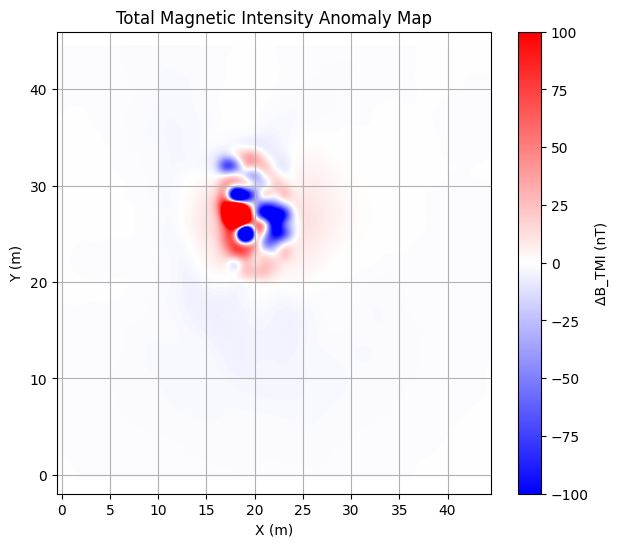

In [4]:
plt.figure(figsize=(7,6))
sc = plt.imshow(dpred_nT.reshape((45,45)),origin='lower',cmap='bwr',vmin=-100,vmax=100,interpolation='bicubic')
plt.colorbar(sc, label='ΔB_TMI (nT)')

plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Total Magnetic Intensity Anomaly Map")
plt.grid(True)
plt.axis('equal')
plt.show()